# ShuffleNetV2

Importando bibliotecas.\
caso a execução deste notebook seja feita localmente, será necessário realizar o download das dependências abaixo.

```
pip install torch torchvision numpy matplotlib seaborn kagglehub
```

Esse notebook foi escrito por:
Felipe Peres de Almeida - 2015310070 \
Guilhermo Aguiar Ferreira - 1415170016

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam

import torchvision
from torchvision.transforms import v2
from torchvision.models import shufflenet_v2_x0_5
from torchvision.models.shufflenetv2 import ShuffleNet_V2_X0_5_Weights

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Verificando se é possível utilizar aceleração por GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


# Carregando Dataset

Primeiro deve ser feito o download do dataset hospedado no kaggle, então utilzaremos o pacote de suporte do kaggle para realizar o download.

```
# Change this cell to code if you're not using kaggle

# Download do Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jcwang10000/pumch-isd")
print(path)
```

In [5]:
path = "/kaggle/input/pumch-isd"

In [6]:
# Verificando classes do dataset
dataset_path = os.path.join(path, os.listdir(path)[0])
classes_path = []
class_name = []

for dataset_class in os.listdir(dataset_path):
  class_name.append(dataset_class)
  classes_path.append(os.path.join(dataset_path, dataset_class))

print("classes_path:\n" + "\n".join(classes_path))

classes_path:
/kaggle/input/pumch-isd/PUMCH-ISD/Acne vulgaris
/kaggle/input/pumch-isd/PUMCH-ISD/Pityriasis rosea
/kaggle/input/pumch-isd/PUMCH-ISD/Dermatitis_subset1
/kaggle/input/pumch-isd/PUMCH-ISD/Rosacea
/kaggle/input/pumch-isd/PUMCH-ISD/Lichen planus
/kaggle/input/pumch-isd/PUMCH-ISD/Vitiligo
/kaggle/input/pumch-isd/PUMCH-ISD/Dermatitis_subset2
/kaggle/input/pumch-isd/PUMCH-ISD/Psoriasis
/kaggle/input/pumch-isd/PUMCH-ISD/Morphea


In [7]:
# Isolando imagens caminho para imagens dermoscópicas
dermoscopic_images_path = [os.path.join(new_class_path, 'dermoscopy') for new_class_path in classes_path]
print("dermoscopic_images_path:\n" + "\n".join(dermoscopic_images_path))

dermoscopic_images_path:
/kaggle/input/pumch-isd/PUMCH-ISD/Acne vulgaris/dermoscopy
/kaggle/input/pumch-isd/PUMCH-ISD/Pityriasis rosea/dermoscopy
/kaggle/input/pumch-isd/PUMCH-ISD/Dermatitis_subset1/dermoscopy
/kaggle/input/pumch-isd/PUMCH-ISD/Rosacea/dermoscopy
/kaggle/input/pumch-isd/PUMCH-ISD/Lichen planus/dermoscopy
/kaggle/input/pumch-isd/PUMCH-ISD/Vitiligo/dermoscopy
/kaggle/input/pumch-isd/PUMCH-ISD/Dermatitis_subset2/dermoscopy
/kaggle/input/pumch-isd/PUMCH-ISD/Psoriasis/dermoscopy
/kaggle/input/pumch-isd/PUMCH-ISD/Morphea/dermoscopy


# Separando Treino/Validação/Teste

In [8]:
images_path = []
images_labels = []

for i, path in enumerate(dermoscopic_images_path):
  img_names = os.listdir(path)
  images_path.extend([os.path.join(path, name) for name in img_names])
  images_labels.extend([class_name[i]] * len(img_names))

X_train, X_temp, y_train, y_temp = train_test_split(images_path, images_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Classe de Dataset e Dataloader

In [9]:
# Iremos utilizar os valores de preprocessamento de imagem dos pesos pré-treinados do modelo ShuffleNet
w = ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1
transform = w.transforms()

# Classe de dataset para utilizar lazy loading do pytorch
class SkinLesionDataset(Dataset):
  def __init__(self, images_path, images_labels, transform=None):
    self.image_paths = images_path
    self.image_labels = images_labels
    self.transform = transform

    self.unique_labels = sorted(list(set(images_labels)))
    self.label_to_int = {label: i for i, label in enumerate(self.unique_labels)}

  def __len__(self):
      return len(self.image_paths)

  def __getitem__(self, idx):
      path = self.image_paths[idx]
      label_str = self.image_labels[idx]

      # Carrega a imagem só neste momento
      image = Image.open(path).convert("RGB")

      if self.transform:
          image = self.transform(image)

      label = self.label_to_int[label_str]

      return image, label

# Separando Dataset entre Treino/Validação/Teste

train_dataset = SkinLesionDataset(X_train, y_train, transform=transform)
val_dataset   = SkinLesionDataset(X_val, y_val, transform=transform)
test_dataset  = SkinLesionDataset(X_test, y_test, transform=transform)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Treino do Modelo

In [10]:
model = shufflenet_v2_x0_5(weights=w) # carrega o modelo shufflenet com pesos prétreinados

# Congelando pesos intermediárias para o transferlearning
for param in model.parameters():
    param.requires_grad = False

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(class_name)) # substitui a camada de classificação original por uma nova

model = model.to(device) # acelerar o treino do modelo com GPU

# Otimizador e Função de Loss
criterion = nn.CrossEntropyLoss()
optim = Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, epochs=10, patience=5):
  best_loss = float('inf')
  patience_counter = 0

  for epoch in range(epochs):
    # --- FASE DE TREINO ---
    model.train() # Coloca o modelo em modo de treino
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zerar gradientes
        optim.zero_grad()

        # Forward (passar dados pela rede)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward (calcular erros e atualizar pesos)
        loss.backward()
        optim.step()

        # Estatísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = 100 * correct_train / total_train
    avg_loss = running_loss / len(train_loader)

    # --- FASE DE VALIDAÇÃO ---
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val
    val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {avg_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Acc: {val_acc:.2f}%")

    # early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth') # saving best trained weights to disk
    else:
        print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

# ---------- Iniciar Treino ----------

EPOCHES = 20
train_model(model, train_loader, val_loader, epochs=EPOCHES)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth
100%|██████████| 5.28M/5.28M [00:00<00:00, 158MB/s]


Epoch [1/20] Train Loss: 2.0100 | Val Loss: 1.8720 | Train Acc: 30.91% | Val Acc: 43.16%
Epoch [2/20] Train Loss: 1.8164 | Val Loss: 1.7158 | Train Acc: 43.07% | Val Acc: 54.10%
Epoch [3/20] Train Loss: 1.6858 | Val Loss: 1.5994 | Train Acc: 49.23% | Val Acc: 55.21%
Epoch [4/20] Train Loss: 1.5883 | Val Loss: 1.5141 | Train Acc: 51.30% | Val Acc: 54.79%
Epoch [5/20] Train Loss: 1.5169 | Val Loss: 1.4486 | Train Acc: 52.27% | Val Acc: 55.56%
Epoch [6/20] Train Loss: 1.4616 | Val Loss: 1.3975 | Train Acc: 53.65% | Val Acc: 56.75%
Epoch [7/20] Train Loss: 1.4185 | Val Loss: 1.3625 | Train Acc: 54.80% | Val Acc: 56.41%
Epoch [8/20] Train Loss: 1.3815 | Val Loss: 1.3317 | Train Acc: 55.44% | Val Acc: 56.07%
Epoch [9/20] Train Loss: 1.3509 | Val Loss: 1.3025 | Train Acc: 55.57% | Val Acc: 56.50%
Epoch [10/20] Train Loss: 1.3207 | Val Loss: 1.2752 | Train Acc: 56.01% | Val Acc: 57.26%
Epoch [11/20] Train Loss: 1.3047 | Val Loss: 1.2651 | Train Acc: 56.89% | Val Acc: 57.95%
Epoch [12/20] Train

# Loading best model from disk

In [11]:
best_model = shufflenet_v2_x0_5()
n_features = best_model.fc.in_features
best_model.fc = nn.Linear(n_features, len(class_name))
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

# Avaliando o modelo nos conjuntos de Teste.

In [12]:
def get_all_predictions(model, loader):
    model.eval() # Modo de avaliação
    all_preds = []
    all_labels = []

    with torch.no_grad(): # Desliga cálculo de gradiente
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1) # Pega o índice da maior probabilidade

            # Move para CPU e converte para numpy para usar no sklearn
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = get_all_predictions(best_model, test_loader)

# Visualizando Resultados

In [13]:
target_names = test_dataset.unique_labels
print(classification_report(y_true, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

     Acne vulgaris       0.66      0.71      0.68       184
Dermatitis_subset1       0.48      0.43      0.45       187
Dermatitis_subset2       0.57      0.24      0.34        95
     Lichen planus       0.64      0.60      0.62       116
           Morphea       0.55      0.74      0.64       129
  Pityriasis rosea       0.86      0.13      0.23        46
         Psoriasis       0.61      0.67      0.64       204
           Rosacea       0.56      0.79      0.65       131
          Vitiligo       0.49      0.46      0.48        78

          accuracy                           0.58      1170
         macro avg       0.60      0.53      0.53      1170
      weighted avg       0.59      0.58      0.57      1170



Text(50.58159722222221, 0.5, 'True')

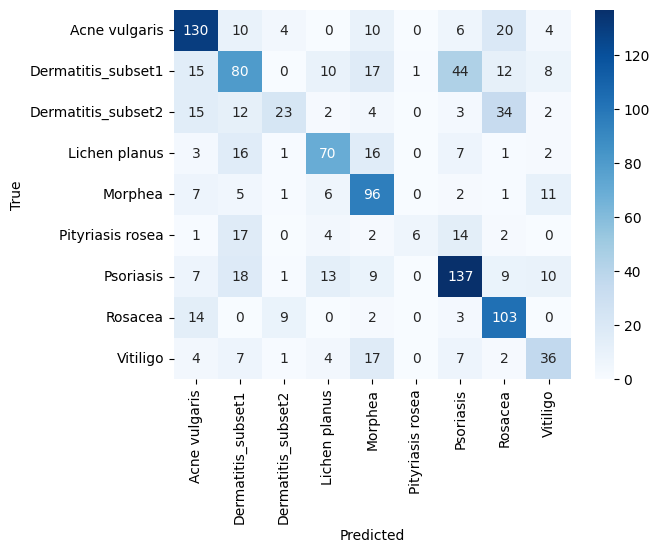

In [14]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')